# AUTOENCODIX PACKAGE HANDBOOK
This notebook demonstrates the usage of the autoencodix package.
For now it serves as an internal guideline with the goal to:
- test the package from a user perspective
- serve as a first draft of user documentation
- serve a developer guideline 
  - developer guide will be derrived from this notebook

## 00 Generate mock data
We provide a variable for example data that can be imported easily. Later we show how to use your own data and what do keep in mind when doing so.

In [1]:
import os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
print(notebook_dir)
os.chdir(notebook_dir)
os.chdir("..")
print(os.getcwd())
# os.chdir(os.path.join(notebook_dir, ".."))

/home/ewald/Github/autoencodix_package/notebooks
/home/ewald/Github/autoencodix_package


In [2]:
from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
raw_sc = EXAMPLE_MULTI_SC

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 01 General Pipeline Usage

In [3]:
import autoencodix as acx
from autoencodix.configs.default_config import DefaultConfig, DataCase

/home/ewald/Github/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(


in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
preprocessing
--- Running Pairing-Aware Split ---
Identified 500 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
cur shape: transcriptomics: (350, 10)
cur shape: proteomics: (350, 10)
cur shape: transcriptomics: (100, 10)
cur shape: proteomics: (100, 10)
cur shape: transcriptomics: (50, 10)
cur shape: proteomics: (50, 10)
Epoch 1 - Train Loss: 6261.1778
Sub-losses: recon_loss: 6261.1778
Epoch 1 - Valid Loss: 352.6898
Sub-losses: recon_loss: 352.6898
Epoch 2 - Train Loss: 5215.1700
Sub-losses: recon_loss: 5215.1700
Epoch 2 - Valid Loss: 348.9782
Sub-losses: recon_loss: 348.9782
Epoch 3 - Train Loss: 4209.2826
Sub-losses: recon_loss: 4209.2826
Epoch 3 - Valid Loss: 322.5976
Sub-losses: recon_loss: 322.5976
Creating plots ...


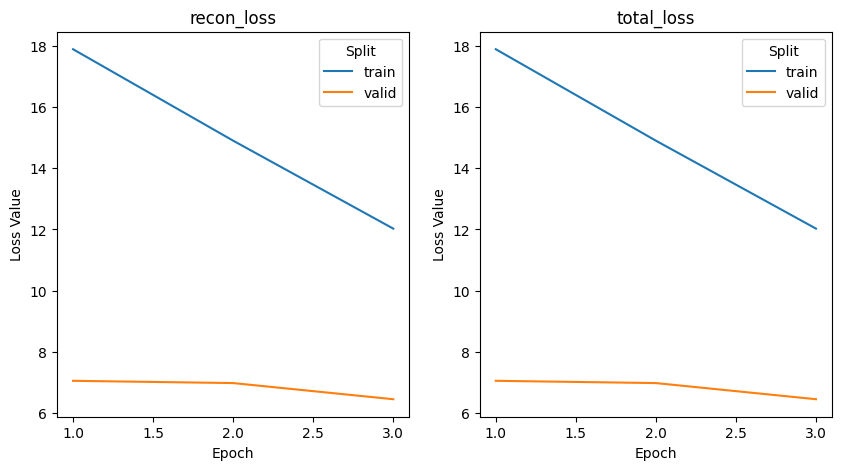

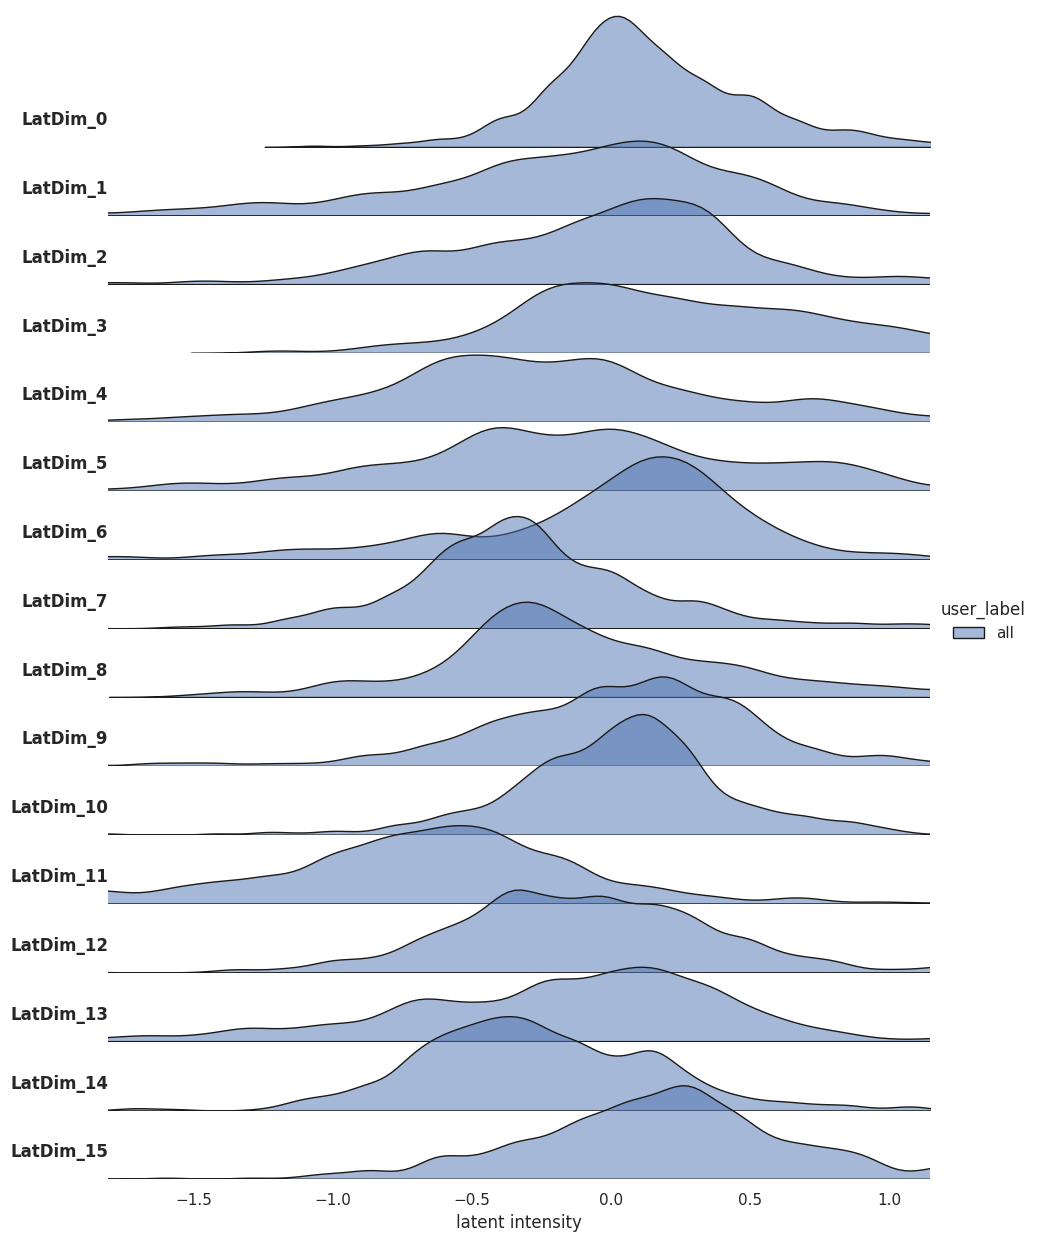

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


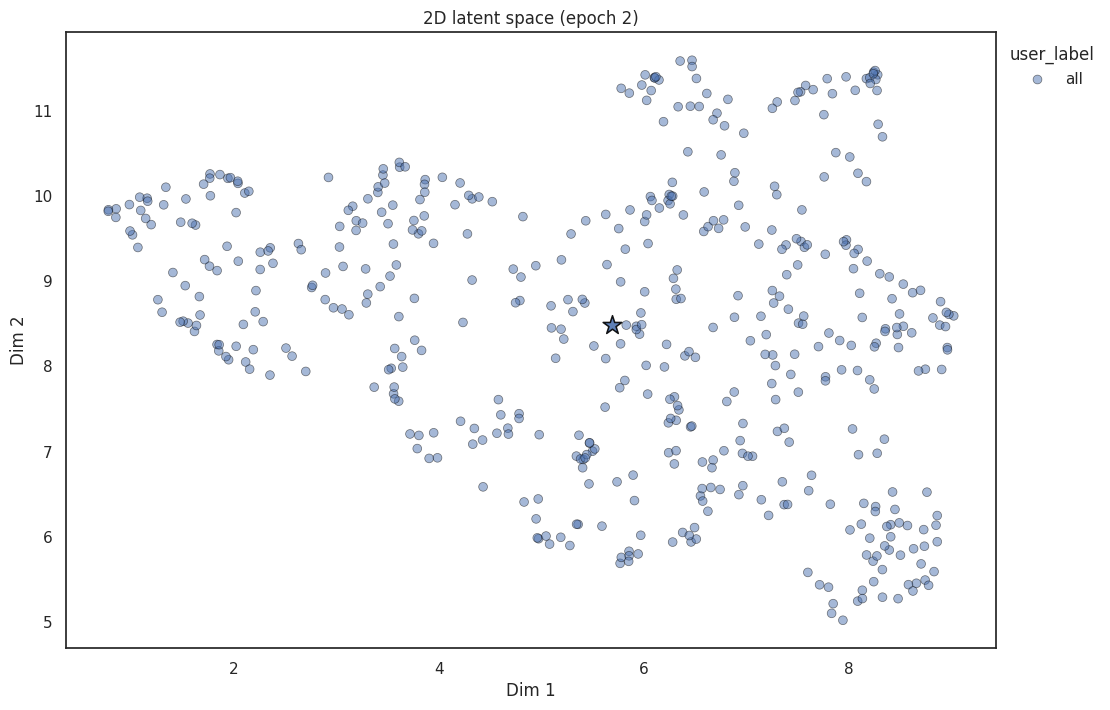

In [4]:
#### --------------------------------------------
### INITIALIZATION ### --------------------------
# Use Vanillix Pipeline interface
# needs to be initialized with data
# data should be a numpy array, pandas dataframe or AnnData object
# possible to pass a custom Config object
# config = DefaultConfig(data_case=DataCase.MULTI_SINGLE_CELL, scaling="MINMAX", batch_size=699)
config = DefaultConfig(data_case=DataCase.MULTI_BULK, scaling="MINMAX")

# van = acx.Vanillix(data=raw_sc, config=config)
van = acx.Vanillix(data=raw_bulk, config=config)
# ------------------------------------------------
### DATA PROCESSING ### --------------------------
# job of old make data
# populates self._datasets attribute with torch datase
# (important for training with dataloader)
# possible to pass a custom Config object, or keyword arguments
van.preprocess()
# ------------------------------------------------
### MODEL TRAINING ### --------------------------
# job of old make model
# calls self.Trainer class to init and train model
# populates self._model attribute with trained model
# populates self.result attribute with training results (model, losses, etc)
van.fit()
# ------------------------------------------------
### PREDICTION ### -------------------------------
# job of old make predict
# if no data is passed, used the test split from preprocessing
# otherwise, uses the data passed, and preprocesses it
# updates self.result attribute with predictions (latent space, reconstructions, etc)
van.predict()
# ------------------------------------------------
### EVALUATION ### -------------------------------
# job of old make ml_task
# populates self.result attribute with ml task results
# van.evaluate()  # not implemented yet
# ------------------------------------------------
### VISUALIZATION ### ---------------------------
# job of old make visualize
# populates self.result attribute with visualizations
van.visualize()
# show visualizations for notebook use
van.show_result()
# --------------------------
# --------------------------

In [5]:
len(van._datasets.train)

350

In [6]:
van.fit()

Epoch 1 - Train Loss: 4594.7432
Sub-losses: recon_loss: 4594.7432
Epoch 1 - Valid Loss: 288.3577
Sub-losses: recon_loss: 288.3577
Epoch 2 - Train Loss: 3741.6230
Sub-losses: recon_loss: 3741.6230
Epoch 2 - Valid Loss: 278.2705
Sub-losses: recon_loss: 278.2705
Epoch 3 - Train Loss: 3149.8101
Sub-losses: recon_loss: 3149.8101
Epoch 3 - Valid Loss: 263.4385
Sub-losses: recon_loss: 263.4385


In [7]:
van.predict()
r = van.result

In [8]:
print(r.sample_ids.get(split="train"))

[['sample_0' 'sample_1' 'sample_10' 'sample_104' 'sample_105'
  'sample_106' 'sample_107' 'sample_109' 'sample_11' 'sample_110'
  'sample_111' 'sample_112' 'sample_115' 'sample_116' 'sample_117'
  'sample_118' 'sample_119' 'sample_12' 'sample_120' 'sample_121'
  'sample_122' 'sample_123' 'sample_125' 'sample_127' 'sample_128'
  'sample_131' 'sample_132' 'sample_133' 'sample_134' 'sample_135'
  'sample_136' 'sample_137' 'sample_138' 'sample_142' 'sample_144'
  'sample_145' 'sample_146' 'sample_147' 'sample_148' 'sample_149'
  'sample_15' 'sample_150' 'sample_151' 'sample_152' 'sample_153'
  'sample_155' 'sample_156' 'sample_16' 'sample_160' 'sample_161'
  'sample_162' 'sample_163' 'sample_164' 'sample_165' 'sample_166'
  'sample_168' 'sample_17' 'sample_170' 'sample_171' 'sample_172'
  'sample_173' 'sample_174' 'sample_177' 'sample_178' 'sample_179'
  'sample_180' 'sample_182' 'sample_183' 'sample_184' 'sample_186'
  'sample_188' 'sample_19' 'sample_191' 'sample_192' 'sample_194'
  'sam

#### Or run all steps in one command

In [9]:
config = DefaultConfig(data_case=DataCase.MULTI_SINGLE_CELL)
van = acx.Vanillix(data=raw_sc, config=config)

result = van.run()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
preprocessing
datapackge in process_multi_single_cell multi_sc:
  multi_sc: 1000 samples × 700 features and multi_sc: {'multi_sc': MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'}
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
--- Running Pairing-Aware Split ---
Identified 1000 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
shape of obj: (1000, 700)
obj: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities

/home/ewald/Github/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(


Epoch 1 - Train Loss: 17991.8122
Sub-losses: recon_loss: 17991.8122
Epoch 1 - Valid Loss: 2049.2698
Sub-losses: recon_loss: 2049.2698
Epoch 2 - Train Loss: 16055.0864
Sub-losses: recon_loss: 16055.0864
Epoch 2 - Valid Loss: 1954.1357
Sub-losses: recon_loss: 1954.1357
Epoch 3 - Train Loss: 14705.3309
Sub-losses: recon_loss: 14705.3309
Epoch 3 - Valid Loss: 1822.7315
Sub-losses: recon_loss: 1822.7315


### Loading and Saving Data

In [10]:
van.save(file_path="van.pkl")
van2 = acx.Vanillix.load("van.pkl")

Pipeline object saved successfully.
Preprocessor saved successfully.
Model state saved successfully.
Attempting to load a pipeline from van.pkl...
Pipeline object loaded successfully. Actual type: Vanillix
Preprocessor loaded successfully.
Model state loaded successfully.


In [11]:
van2.result.model

VanillixArchitecture(
  (_encoder): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=16, bias=True)
  )
  (_decoder): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=16, out_feature

In [12]:
import torch

recon = van.decode(latent=torch.zeros((10, 16)))
recon.shape

torch.Size([10, 20])

In [13]:
van.result.datasets.test.sample_ids

['cell_107',
 'cell_189',
 'cell_191',
 'cell_193',
 'cell_108',
 'cell_20',
 'cell_214',
 'cell_11',
 'cell_22',
 'cell_226',
 'cell_227',
 'cell_232',
 'cell_234',
 'cell_24',
 'cell_246',
 'cell_250',
 'cell_252',
 'cell_255',
 'cell_114',
 'cell_263',
 'cell_115',
 'cell_271',
 'cell_275',
 'cell_278',
 'cell_281',
 'cell_283',
 'cell_284',
 'cell_288',
 'cell_295',
 'cell_301',
 'cell_306',
 'cell_311',
 'cell_313',
 'cell_315',
 'cell_329',
 'cell_332',
 'cell_338',
 'cell_340',
 'cell_341',
 'cell_344',
 'cell_345',
 'cell_35',
 'cell_123',
 'cell_350',
 'cell_353',
 'cell_355',
 'cell_362',
 'cell_100',
 'cell_371',
 'cell_376',
 'cell_378',
 'cell_38',
 'cell_382',
 'cell_383',
 'cell_385',
 'cell_388',
 'cell_394',
 'cell_396',
 'cell_4',
 'cell_403',
 'cell_409',
 'cell_436',
 'cell_44',
 'cell_441',
 'cell_445',
 'cell_456',
 'cell_134',
 'cell_467',
 'cell_474',
 'cell_477',
 'cell_137',
 'cell_487',
 'cell_490',
 'cell_507',
 'cell_514',
 'cell_522',
 'cell_534',
 'cell_5

In [14]:
recon = van.decode(latent=van.result.adata_latent)
print(recon.shape)

(200, 20)


In [15]:
recons = result.reconstructions.get(split="train", epoch=2)
recons_val = result.reconstructions.get(split="valid", epoch=2)
recons_test = result.reconstructions.get(split="test", epoch=-1)

print(f"Training reconstruction shape: {recons.shape} (samples x features)")
print(f"Validation reconstruction shape: {recons_val.shape} (samples x features)")
print(f"Test reconstruction shape: {recons_test.shape} (samples x features)")
print(
    f"Total reconstructed samples: {recons.shape[0] + recons_val.shape[0] + recons_test.shape[0]}"
)

Training reconstruction shape: (700, 20) (samples x features)
Validation reconstruction shape: (100, 20) (samples x features)
Test reconstruction shape: (200, 20) (samples x features)
Total reconstructed samples: 1000


In [16]:
latents = result.latentspaces.get(split="train", epoch=2)
latents_val = result.latentspaces.get(split="valid", epoch=2)
latents_test = result.latentspaces.get(split="test", epoch=-1)

print(
    f"Training latent representations: {latents.shape} (n_samples={latents.shape[0]}, latent_dim={latents.shape[1]})"
)
print(
    f"Validation latent representations: {latents_val.shape} (n_samples={latents_val.shape[0]}, latent_dim={latents_val.shape[1]})"
)
print(
    f"Test latent representations: {latents_test.shape} (n_samples={latents_test.shape[0]}, latent_dim={latents_test.shape[1]})"
)
print(
    f"Total encoded samples: {latents.shape[0] + latents_val.shape[0] + latents_test.shape[0]}"
)
print(f"Latent space dimensionality: {latents.shape[1]}")


Training latent representations: (700, 16) (n_samples=700, latent_dim=16)
Validation latent representations: (100, 16) (n_samples=100, latent_dim=16)
Test latent representations: (200, 16) (n_samples=200, latent_dim=16)
Total encoded samples: 1000
Latent space dimensionality: 16


#### Using a custom train, test, valid split
When you pass the data to the pipeline, autoencodix, internally splits the data for you based on the train,test, valid ratios provided in the config (defaults are 70%/10%/20% train/valid/test).
You can either pass custom ratios (see next section) or provide the indices directly as shown below

In [17]:
import numpy as np
from autoencodix.configs.default_config import DataCase

sample_data = np.random.rand(100, 10)
custom_train_indices = np.arange(75)  # we won't allow overlap between splits
custom_valid_indices = np.arange(75, 80)
custom_test_indices = np.arange(80, 100)

# the custom split needs to be a dictionary with keys "train", "valid", and "test" and indices of the samples to be included in each split as numpy arrays
custom_split = {
    "train": custom_train_indices,
    "valid": custom_valid_indices,
    "test": custom_test_indices,
}
config = DefaultConfig(data_case=DataCase.MULTI_BULK)
van = acx.Vanillix(data=raw_bulk, custom_splits=custom_split, config=config)
van.preprocess()
van.fit()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
preprocessing
--- Running Pairing-Aware Split ---
Identified 500 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
cur shape: transcriptomics: (350, 10)
cur shape: proteomics: (350, 10)


cur shape: transcriptomics: (100, 10)
cur shape: proteomics: (100, 10)
cur shape: transcriptomics: (50, 10)
cur shape: proteomics: (50, 10)


/home/ewald/Github/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(


Epoch 1 - Train Loss: 9607.1356
Sub-losses: recon_loss: 9607.1356
Epoch 1 - Valid Loss: 1002.5187
Sub-losses: recon_loss: 1002.5187
Epoch 2 - Train Loss: 9068.8843
Sub-losses: recon_loss: 9068.8843
Epoch 2 - Valid Loss: 1018.1221
Sub-losses: recon_loss: 1018.1221
Epoch 3 - Train Loss: 8639.4532
Sub-losses: recon_loss: 8639.4532
Epoch 3 - Valid Loss: 1016.9384
Sub-losses: recon_loss: 1016.9384


It is possible to pass empty splits, but depending on how you'll use the autoencodix pipeline, this will throw an error at some point. So it is possible to call `fit` with only training data, but if you want to call `predict` and don't provide new data, this won't work without a data in the test split

#### Using predict with new data
The standard case is to train the model with the train data and then predict with the test split.
However, it is possible to pass new data to the predict method to perform inference on this data with the already trained model.

Here you have two options:
1. Provide a fully processed dataset (similiar to `EXAMPLE_PROCESSED_DATA`) See the section `Work with you own data` for details.
2. Provide raw data, which will be processed before predicting (also see `Work with your own data`)

You pass the data with the keyword argument `data`, and depending on the datatype, the pipeline knows whether to preprocess or not.

In [18]:
# assume new data
new_data = raw_bulk
van.predict(data=new_data)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
cur shape: transcriptomics: (500, 10)
cur shape: proteomics: (500, 10)


n_samples in format recon: 500
train
test
n_samples from datatpackge: {'paired_count': 500}


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VanillixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x750251dc8790>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x75024b77bc40>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x75024b77add0>)
new_datasets: DatasetContainer(train=None, valid=None, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x750251dc8760>)
adata_latent: AnnData object with n_obs × n_vars = 500 × 16
    uns: 'var_names'
final_reconstruction: multi_bulk:
  transcriptomics: 50

#### Examining the result of the pipeline
Each step in the pipeline writes its results in the result object of the Vanillix instance.
In this section we explore how to access and make sense of the results.

In [19]:
result = van.result
print(result)

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VanillixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x750251dc8790>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x75024b77bc40>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x75024b77add0>)
new_datasets: DatasetContainer(train=None, valid=None, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x750251dc8760>)
adata_latent: AnnData object with n_obs × n_vars = 500 × 16
    uns: 'var_names'
final_reconstruction: multi_bulk:
  transcriptomics: 50

##### TrainingDynamics object in result
The training dynamics object has the followinf form:
<epoch><split><data>
So if you want to access the train loss for the 5th epoch, you would:
`result.lossss.get(epoch=5, split="train")`

##### The `.get()` Method Explained

The `reconstructions.get()` method provides flexible access to reconstruction data stored during training. It can retrieve data for specific epochs, specific splits, or any combination of these parameters.


##### Parameters:

- **`epoch`** (Optional[int]): 
  - Positive integer (e.g., `2`): Get reconstructions from that specific epoch
  - Negative integer (e.g., `-1`): Get the latest epoch (-1), second-to-last (-2), etc.
  - `None`: Return data for all epochs

- **`split`** (Optional[str]):
  - Valid values: "train", "valid", "test"
  - `None`: Return data for all splits

##### Return Value Behavior:

The method returns different types depending on the parameters:

1. **Both `epoch` and `split` specified**:
   - Returns a NumPy array for that specific epoch and split
   - Example: `get(epoch=2, split="train")` → `array([...])` 

2. **Only `epoch` specified**:
   - Returns a dictionary of all splits for that epoch
   - Example: `get(epoch=2)` → `{"train": array([...]), "valid": array([...]), ...}`

3. **Only `split` specified**:
   - Returns a NumPy array containing data for that split across all epochs
   - Example: `get(split="train")` → `array([[...], [...], ...])` (first dimension represents epochs)

4. **Neither specified**:
   - Returns the complete nested dictionary structure
   - Example: `get()` → `{0: {"train": array([...])}, 1: {...}, ...}`

##### Special Handling:

- If an invalid split is provided, a `KeyError` is raised
- Negative epoch indices work like Python list indexing (-1 is the last epoch)
- If an epoch doesn't exist, an empty array or dictionary is returned

##### Code Example:

In [20]:
loss_train_ep2 = result.losses.get(epoch=2, split="train")
print(loss_train_ep2)
valid_loss = result.losses.get(split="valid")
print(valid_loss)
print(result.losses.get())

24.684152134486606
[20.05037476 20.36244263 20.33876709]
{0: {'train': array(27.44895874), 'valid': array(20.05037476)}, 1: {'train': array(25.91109811), 'valid': array(20.36244263)}, 2: {'train': array(24.68415213), 'valid': array(20.33876709)}}


In [21]:
from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    # EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
# raw_sc = EXAMPLE_MULTI_SC

Note: this schema works for every TrainingDynamics instance in the results object.

### 02 How to get information about the default config parameters

In [22]:
# if you want to see what config parameters are used in the default config you can do it like:
default_config = DefaultConfig()
default_config.print_schema()


DefaultConfig Configuration Parameters:
--------------------------------------------------

data_config:
  Type: <class 'autoencodix.configs.default_config.DataConfig'>
  Default: data_info={} require_common_cells=False annotation_columns=None
  Description: No description available

requires_paired:
  Type: typing.Optional[bool]
  Default: PydanticUndefined
  Description: Indicator if the samples for the xmodalix are paired, based on some sample id

data_case:
  Type: typing.Optional[autoencodix.configs.default_config.DataCase]
  Default: PydanticUndefined
  Description: Data case for the model, will be determined automatically

k_filter:
  Type: typing.Optional[int]
  Default: 20
  Description: Number of features to keep

scaling:
  Type: typing.Literal['STANDARD', 'MINMAX', 'ROBUST', 'MAXABS', 'NONE']
  Default: STANDARD
  Description: Setting the scaling here for all data modalities, can per overruled by setting scaling at data modality level per data modality

skip_preprocessing:

### 02.1 Documentation Config class
You can update the config with your own values by:
- passing arguments as:
    - dict
    - single arguments
- passing a file (sample configs and data can be found [here](https://cloud.scadsai.uni-leipzig.de/index.php/s/54aL6E6QebHDXPy)).

In [23]:
from autoencodix.configs.default_config import DefaultConfig
import yaml
from pathlib import Path

# METHOD 1: override the default config with a dictionary
my_args = {"learning_rate": 0.0234, "batch_size": 13, "epochs": 12}
my_config = DefaultConfig(**my_args)
# METHOD 2: override signle parameters
my_new_conig = DefaultConfig(latent_dim=23, n_gpus=13)

# METHOD 3: from a file:
custom_config = DefaultConfig.model_validate(
    {
        **yaml.safe_load(Path("configs/multi_bulk.yaml").read_text()),
        "learning_rate": 0.77,
    }
)

## 03 Use the Varix model
Now we show how easy it is to use a variational autoencoder instead of a vanilla version.

In [24]:
from autoencodix.configs.default_config import DefaultConfig
from autoencodix.configs.default_config import DataCase
import autoencodix as acx

my_config = DefaultConfig(
    learning_rate=0.001, epochs=3, pretrain_epochs=0, checkpoint_interval=1
)
my_config.data_case = DataCase.MULTI_BULK
van = acx.Varix(data=processed_data, config=my_config)
result = van.run()

preprocessing


/home/ewald/Github/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.varix_config.VarixConfig'> work best
  warnings.warn(


Epoch 1 - Train Loss: 862952.3242
Sub-losses: recon_loss: 862952.1895, var_loss: 0.1306, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 121781.6987
Sub-losses: recon_loss: 121781.6870, var_loss: 0.0067, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 851974.1016
Sub-losses: recon_loss: 851868.9395, var_loss: 105.1550, anneal_factor: 0.0344, effective_beta_factor: 0.0344
Epoch 2 - Valid Loss: 120127.2378
Sub-losses: recon_loss: 120119.6040, var_loss: 7.6330, anneal_factor: 0.0344, effective_beta_factor: 0.0344
Epoch 3 - Train Loss: 843603.0625
Sub-losses: recon_loss: 840462.5273, var_loss: 3140.5413, anneal_factor: 0.9656, effective_beta_factor: 0.9656
Epoch 3 - Valid Loss: 119040.6853
Sub-losses: recon_loss: 118764.5042, var_loss: 276.1806, anneal_factor: 0.9656, effective_beta_factor: 0.9656


In [25]:
my_config.pretrain_epochs

0

In [26]:
print(result.datasets.train.feature_ids)
print(my_config.data_case)

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29']
DataCase.MULTI_BULK


#### Examine Variational result
Here, we have more info in our results object than in the Vanillix case. We have the learned paramters mu and logvar of the normal distirbution, in addition to the losses and reconstructions. We provide also the sampled latentspaces at each epoch and split.

You can resample new latenspaces (shown in next section)

In [27]:
# we did not train for the test split, so we don't need to pass an epoch
# technically the epoch is -1
mu_test_ep_last = result.latentspaces.get(split="test")
print(mu_test_ep_last.shape)

(1, 201, 16)


#### Different loss types
For our variation autoencoder, the total loss consists of a reconstruction loss and a distribution loss i.e. kl-divergence. To investigate these losses, the result_obj has the attribute `sub_losses`. This is a `LossRegistry` withe the name of the loss as key and the value is of class `TrainingDynamics` and can be accessed as shown for the Vanillix part

In [28]:
sub_losses = result.sub_losses
print(f"keys: {sub_losses.keys()}")
recon_dyn = sub_losses.get(key="recon_loss")
print(recon_dyn.get(split="train"))

keys: dict_keys(['recon_loss', 'var_loss', 'anneal_factor', 'effective_beta_factor'])
[1234.55248849 1218.69662297 1202.37843683]


#### Sample new latentspaces
You might want to use the trained model and the fitted parameters mu, and logvar to sample latentspaces. Therefore, the Varix pipeline has the additional method `sample_latent_space`

In [29]:
sampled = van.sample_latent_space()

print(sampled[:5])

tensor([[-0.4707,  0.7376,  1.4181,  0.9243,  0.8444, -1.5456,  0.8706,  0.0061,
          0.3648,  0.0421, -2.0873, -1.8099, -0.5154,  1.5034,  0.3872,  1.6025],
        [ 0.8293,  1.2567,  0.2603, -1.4167, -0.3379, -0.7733, -1.0714,  0.4476,
         -0.3493,  0.5827,  2.7544,  0.4216, -1.0986,  0.2383,  1.5050, -0.1311],
        [ 1.1670,  0.2715,  0.1907, -0.0844,  1.2832,  0.5304,  1.4039, -0.1986,
          0.7465, -0.6213,  0.3474, -1.0449,  0.2932,  0.5769,  1.6338, -0.6476],
        [-0.2605,  2.8422, -2.0418,  1.6374,  1.8335,  0.1361, -1.4537, -0.4999,
          2.3816, -0.6510, -0.4682, -1.8412,  1.4674,  0.1258,  0.8621,  1.5865],
        [-0.0761, -0.7162, -1.1942,  1.1732,  0.9124,  0.6388,  2.2886,  0.3640,
         -0.2287, -3.1111, -1.7636, -0.7516, -0.5999, -0.4269,  0.0848,  2.2835]])


In [30]:
# you can also select a specific epoch and split to sample from (default is last epoch and test split)
sampled = van.sample_latent_space(epoch=2, split="valid")
print(sampled[:5])

tensor([[ 0.9208, -1.1755,  0.1732,  1.6875,  0.8495,  0.5711, -0.9182,  2.1648,
         -0.2166,  2.0450, -1.2371, -0.2121, -0.4391,  0.0244, -0.5882,  0.4754],
        [-0.2372,  1.3406, -1.1397,  2.2556,  0.0702,  0.9426,  2.3356, -1.7969,
         -0.6313,  0.0663,  1.1111, -0.4261,  0.2684, -0.4398,  0.0167,  0.4323],
        [ 1.0166, -1.4174, -0.3301, -2.0247,  1.1598,  1.0837,  3.6547,  1.7421,
          0.3261,  2.1438, -0.3715,  0.8205,  0.9813,  0.1941,  0.4290, -0.8642],
        [-1.8787,  0.2442,  0.6227,  0.6530,  0.9660,  0.5073,  1.1831, -0.6608,
          0.7290, -0.7453, -0.2737, -0.5837, -0.1091,  0.3551,  0.0503,  0.1177],
        [ 0.1615, -1.0775,  0.4223,  0.9182,  3.0960,  1.2181, -1.4152, -0.6262,
         -1.4376, -0.9562, -0.9618,  1.4038,  0.3039,  0.0293, -0.0653,  1.2327]])


In [31]:
# or sample multiple times
for _ in range(5):
    sampled = van.sample_latent_space()
    print(sampled[:3, :3])

tensor([[ 0.0220, -0.4803,  0.8225],
        [ 3.3302,  1.1639, -0.0783],
        [ 0.6845, -0.4809,  1.2057]])
tensor([[ 1.8553, -1.0779,  0.6983],
        [ 0.0158,  1.9275,  0.3249],
        [ 2.6661, -0.5704,  0.6001]])
tensor([[ 0.4689,  2.1125,  1.9214],
        [ 0.0738, -0.0531,  0.2856],
        [-3.9490, -0.4665,  1.5214]])
tensor([[ 1.5579, -0.0751, -1.1305],
        [ 1.3456, -1.1660,  0.7330],
        [-1.0457, -0.1499,  0.5592]])
tensor([[ 1.7354, -1.6793, -1.7403],
        [-2.1487,  1.6676, -0.4183],
        [ 0.7620, -1.2736,  0.7925]])


## 04 Work with your own data
In the above steps we showed how to use `Autoencodix` with mock data. Nowe we demonstrate how to use real-world data. There are three main use cases:
1. Use data from raw files and define the path and metainfo via the config (file or DefaultConfig class).
2. Provide the raw data directly in Python and pass it to our `DataPackage` structure. This `DataPackage` then can be passed to to our Pipeline where it will pre preprocessed.
3. Take care of the preprocessing yourself and pass the `DatasetContainer` to our pipeline. We show how to fill this `DatasetContainer` object with your preprocsedded data.

### 04.1 Working with data from files
Here we specialize on different kind of omics data. We cover:
1. combining multi-omics data from bulk sequencing (e.g. mRNA and methylation).
2. combining multi-omics data from single cell sequencing.
3. "Translating" between multi-omics data e.g. scRNA <-> scATAC, or bulkmRNA <-> bulkmiRNA
4. Working with image data
5. "translating" between data-modalities
  - one bulk-omics modality to another
  - omics to image an vice versa

#### 04.1.1 Combining mulit-omics data from bulk-sequencing
First we need to prepare our config object. We can (a) directly provide an object in python, or (b) provide an YAML file. We show both

##### YAML config
Assume we have the file in `./config.yaml`.
We can keep the yaml file structure to define our input data like:
```yaml
data_config: # has to be named data_config
  data_info: # has to be named data_infor
   RNA: # name can be chosen by user
     file_path: "data/raw/data_mrna_seq_v2_rsem_formatted.parquet"
     is_single_cell: false # default false, added for verbosity
   METHYLATION: # can be chosen by user
     file_path: "data/raw/data_methylation_per_gene_formatted.parquet"
     is_single_cell: false # default false, added for verbosity
   CLINICAL: # can be chosen by user
     file_path: "data/raw/data_clinical_formatted.parquet"
     data_type: "ANNOTATION" # default NUMERIC (as for RNA and METHYLATION)
```
ATTENTION:
If you use `.txt` or `.csv` files, it is best practice to add the `sep` parameter. If none is given, the reader will try to auto-detect the separator, which is error prone.
This would loke like:
```YAML
    RNA:
      ...
      sep: "\t" # for tab, ";" or "," would be also possible (as in pandas)

```
**IMPORTANT**

For all your bulk data files, we expect the first column to be some kind of unique sample id. Please prepare the data accordingly.

In [32]:
import yaml
from pathlib import Path
from autoencodix.configs.default_config import DefaultConfig
import os

print(os.getcwd())
# this fills the data_config attribute of the DefaultConfig object
# we can also change the default values in the config.yaml file
# or via the DefaultConfig object
bulk_config = DefaultConfig.model_validate(
    yaml.safe_load(Path("configs/multi_bulk.yaml").read_text())
)
# this bulk_config object can then be passed to a Pipeline (Varix, Vanillix, etc)
var_bulk = acx.Varix(config=bulk_config)

/home/ewald/Github/autoencodix_package


/home/ewald/Github/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.varix_config.VarixConfig'> work best
  warnings.warn(


In [35]:
var_bulk.config.print_schema()


DefaultConfig Configuration Parameters:
--------------------------------------------------

data_config:
  Type: <class 'autoencodix.configs.default_config.DataConfig'>
  Default: data_info={} require_common_cells=False annotation_columns=None
  Description: No description available

requires_paired:
  Type: typing.Optional[bool]
  Default: PydanticUndefined
  Description: Indicator if the samples for the xmodalix are paired, based on some sample id

data_case:
  Type: typing.Optional[autoencodix.configs.default_config.DataCase]
  Default: PydanticUndefined
  Description: Data case for the model, will be determined automatically

k_filter:
  Type: typing.Optional[int]
  Default: 20
  Description: Number of features to keep

scaling:
  Type: typing.Literal['STANDARD', 'MINMAX', 'ROBUST', 'MAXABS', 'NONE']
  Default: STANDARD
  Description: Setting the scaling here for all data modalities, can per overruled by setting scaling at data modality level per data modality

skip_preprocessing:

In [33]:
result = var_bulk.run()

preprocessing


FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/mini/bulk/rna_sample_data.csv'

We can also overwrite or add values to our config from the config file.

In [ ]:
# with custom values
custom_config = DefaultConfig.model_validate(
    {
        **yaml.safe_load(Path("configs/multi_bulk.yaml").read_text()),
        "learning_rate": 0.77,
    }
)

##### Create DataConfig in Python
Instead of reading the config from the file, we can also create it directly in Ptyon
We will only use one way of config creation for the next examples.

In [ ]:
from autoencodix.configs.default_config import DataConfig, DataInfo

root_dir = os.path.join("data/raw")
meth_file = "data_methylation_per_gene_formatted.parquet"
mrna_file = "data_mrna_seq_v2_rsem_formatted.parquet"
clin_file = "data_clinical_formatted.parquet"

bulk_config = DefaultConfig(
    scaling="MINMAX",
    data_config=DataConfig(
        data_info={
            "RNA": DataInfo(file_path=os.path.join(root_dir, mrna_file),scaling="STANDARD"),
            "METHYLATION": DataInfo(file_path=os.path.join(root_dir, meth_file)),
            "CLINICAL": DataInfo(
                file_path=os.path.join(root_dir, clin_file), data_type="ANNOTATION"
            ),
        }
    )
)
#

In [ ]:
van = acx.Vanillix(config=bulk_config)
r = van.run()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(


preprocessing
bulk_dfs keys in process_multi_bulk: dict_keys(['RNA', 'METHYLATION'])
--- Running Pairing-Aware Split ---
Identified 10013 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
cur shape: RNA: (7008, 10)
cur shape: METHYLATION: (7008, 10)
cur shape: RNA: (2003, 10)
cur shape: METHYLATION: (2003, 10)
cur shape: RNA: (1002, 10)
cur shape: METHYLATION: (1002, 10)
Epoch 1 - Train Loss: 98558.9024
Sub-losses: recon_loss: 98558.9024
Epoch 1 - Valid Loss: 9461.7361
Sub-losses: recon_loss: 9461.7361
Epoch 2 - Train Loss: 71869.4587
Sub-losses: recon_loss: 71869.4587
Epoch 2 - Valid Loss: 7445.8082
Sub-losses: recon_loss: 7445.8082
Epoch 3 - Train Loss: 64336.7631
Sub-losses: recon_loss: 64336.7631
Epoch 3 - Valid Loss: 6441.8762
Sub-losses: recon_loss: 6441.8762


In [ ]:
print(van._preprocessor._datapackage_dict["train"]["data"].multi_bulk["METHYLATION"].max())
print(van._preprocessor._datapackage_dict["train"]["data"].multi_bulk["METHYLATION"].min())


print(van._preprocessor._datapackage_dict["train"]["data"].multi_bulk["RNA"].mean())
print(van._preprocessor._datapackage_dict["train"]["data"].multi_bulk["RNA"].var())

Entrez_Gene_Id
7710      1.0
10551     1.0
140886    1.0
257144    1.0
57821     1.0
51316     1.0
8433      1.0
397       1.0
27071     1.0
861       1.0
dtype: float64
Entrez_Gene_Id
7710      0.0
10551     0.0
140886    0.0
257144    0.0
57821     0.0
51316     0.0
8433      0.0
397       0.0
27071     0.0
861       0.0
dtype: float64
Entrez_Gene_Id
213     0.000000e+00
7038    0.000000e+00
1277    6.083414e-17
1113   -3.244487e-17
1114    1.622244e-17
5265    2.433366e-17
3240    2.433366e-17
2670    0.000000e+00
5644    0.000000e+00
2335   -1.297795e-16
dtype: float64
Entrez_Gene_Id
213     1.000143
7038    1.000143
1277    1.000143
1113    1.000143
1114    1.000143
5265    1.000143
3240    1.000143
2670    1.000143
5644    1.000143
2335    1.000143
dtype: float64


#### 04.1.2 Working with single cell data from different sequencing processes
First we define our config again, then we use the reader object to build the MuData object (this will look more familar for single cell practioners)

We can provide a config yaml like:
```yaml
# config.yaml
data_config:
 data_info:
   RNA:
     file_path: "data/raw/Sc-1.h5ad" # we request h5ad files
     is_single_cell: true
     min_cells: 0.01
     min_genes: 0.01
     is_X: true
   METH:
     file_path: "data/raw/Sc-2.h5ad"
     is_single_cell: true
     min_cells: 0.01
```

In [ ]:
from autoencodix.configs import DefaultConfig
import yaml
from pathlib import Path

scconfig = DefaultConfig.model_validate(
    yaml.safe_load(Path("configs/largesc.yaml").read_text())
)

In [ ]:
import autoencodix as acx

sc_van = acx.Vanillix(config=scconfig)

sc_van.preprocess()
# result = sc_van.run()

preprocessing


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Number of common cells: 4354
datapackge in process_multi_single_cell multi_sc:
  multi_sc: 4354 samples × 18018 features and multi_sc: {'multi_sc': View of MuData object with n_obs × n_vars = 4354 × 18018
  2 modalities
    RNA:	4354 x 9009
      obs:	'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
      var:	'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
      uns:	'batch_conditio

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:

In [ ]:
sc_van.fit()

Epoch 1 - Train Loss: 160376.8513
Sub-losses: recon_loss: 160376.8513
Epoch 1 - Valid Loss: 18644.7593
Sub-losses: recon_loss: 18644.7593
Epoch 2 - Train Loss: 126594.7552
Sub-losses: recon_loss: 126594.7552
Epoch 2 - Valid Loss: 14323.8984
Sub-losses: recon_loss: 14323.8984
Epoch 3 - Train Loss: 104746.0287
Sub-losses: recon_loss: 104746.0287
Epoch 3 - Valid Loss: 12111.6981
Sub-losses: recon_loss: 12111.6981


In [ ]:
import scanpy as sc

filepath = "data/raw/Sc-2-mini.h5ad"
adata = sc.read(filepath)
print(adata)

AnnData object with n_obs × n_vars = 4554 × 9009
    obs: 'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_joint_wnn_umap', 'X_umap'
    layers: 'log2_X', 'log_X'


In [ ]:
sc_van._datasets.test.data.size()

torch.Size([871, 50])

In [ ]:
sc_van._datasets.train.data.size()

torch.Size([3047, 50])

Again, we can pass the `scconfig` to our Pipeline as shown with the bulk example.

#### 04.1.3 Translating between omics data
We only allow bulk to bulk and single-cell to single cell. The config is almost identical to the case before, we only add the direction of the translation like:
```YAML
data_config:
 data_info:
   RNA:
     file_path: "data/raw/Sc-1.h5ad"
     is_single_cell: true
     min_cells: 0.01
     min_genes: 0.01
     is_X: true
     translate_direction: "FROM"
   METH:
     file_path: "data/raw/Sc-2.h5ad"
     is_single_cell: true
     min_cells: 0.01
     translate_direction: "TO"

```

For the bulk case we can keep annotation data without including it in the translation like:
```YAML
# config.yaml
data_config:
  data_info:
   RNA:
     file_path: "data/raw/data_mrna_seq_v2_rsem_formatted.parquet"
     is_single_cell: false
     translate_direction: "FROM"
   METHYLATION:
     file_path: "data/raw/data_methylation_per_gene_formatted.parquet"
     is_single_cell: false
     translate_direction: "TO"
   CLINICAL:
     file_path: "data/raw/data_clinical_formatted.parquet"
     data_type: "ANNOTATION"
     # default translate_direction is  NONE, so we don't need to specify it here
```

#### 04.1.4 Working with images
When working with images, we need have two cases:
- pure image, without translating
- translating between omics and images

In the first case we need to provide the folder path of the images. In the second case we need to provide the folder path of the images and an annotation file that maps the metadata for the images to the image filenames. In this file we also need to map the sample_ids of the other data modality to the image filename and metadata. Later we will add support for an unpaired case, where we only provide image metadata without mapping to the other data modality.
The file should look like this:
**important**: this file needs to contain the columns `sample_ids` and `img_paths`
```text
sample_ids	img_paths	METADATA1	METADATA2
TCGA-05-4244-01	0_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4249-01	1_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4250-01	2_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4382-01	3_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4384-01	4_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4389-01	5_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4390-01	6_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4395-01	7_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4396-01	8_label_1.png	Non-Small Cell Lung Cancer	LUAD
```

##### Image only case

In [ ]:
from autoencodix.configs.default_config import DataConfig, DataInfo

img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(file_path="data/raw/images/tcga_fake", data_type="IMG"),
            "ANNO": DataInfo(
                file_path="data/raw/tcga_mappings.txt", data_type="ANNOTATION"
            ),
        }
    )
)

##### Images and omics data
If you want to translate between image and another data modality you need to provide the same files as above. For the Annotation files you have two possibilities: (a) you provide one annotation file (as shown above), in this file you match the metadata of the two data modalites, by an shared sample_id / mapping of sample_id and image_path and other metadata. (b) you can have supply an extra annotation file for the images with the attribute `img_anno_file`. If None is given, we will use the shared file. This is only allowed for unpaired translation.
So for the unpaired translation the `DataConfig` should look like:

In [ ]:
from autoencodix.configs.default_config import DataConfig, DataInfo, DefaultConfig

img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path="data/raw/images/tcga_fake",
                data_type="IMG",
                translate_direction="to",
            ),
            "RNA": DataInfo(
                file_path="data/raw/data_mrna_seq_v2_rsem_formatted.parquet",
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "ANNO": DataInfo(
                file_path="data/raw/tcga_mappings.txt",
                data_type="ANNOTATION",
            ),
        }
    )
)

In [ ]:
from autoencodix.utils._imgreader import ImageDataReader

imgreader = ImageDataReader()
imgdata, img_anno = imgreader.read_data(config=img_config)

Checking data type: IMG
Found image type in config
current data info: file_path='data/raw/images/tcga_fake' data_type='IMG' scaling='NONE' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to' pretrain_epochs=0
Checking data type: RNA
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/raw/tcga_mappings.txt


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


Successfully loaded 3204 images for IMG


In [ ]:
print(imgdata.keys())
print(f"Number of images: {len(imgdata['IMG'])}")

dict_keys(['IMG'])
Number of images: 3204


##### Unpaired case
This case is not implemented in the old version of `autoencodix` and will be added after the other translating features, we still show how the config can look like:
```python
from autoencodix.configs.default_config import DataConfig, DataInfo
img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path="data/raw/images/tcga_fake.txt",
                data_type="IMG",
                translate_direction="to"
                extra_anno_file="path/to/file"
            ),
            "RNA": DataInfo(
                file_path="data/raw/data_mrna_seq_v2_rsem_formatted.parquet",
                data_type="NUMERIC",
                translate_direction="from"
            ),
            "ANNO": DataInfo(
                file_path="data_clinical_formatted.parquet",
                data_type="ANNOTATION",
            ),
        }
    )
)


#### 04.1 How to use raw data 
If you don't want to provide files via config, you can create a DataPackage directly in Python. First you need to decide what kind of data you use. We currently support the following cases:
- Multi-Bulk (or any other numeric data)
- Multi-SingleCell (or standard Single Cell)
- Bulk-to-Bulk translation
- SingleCell-to-SingleCell translation
- Image-Bulk translation or vice versa
- SingleCell-Image translation or vice versa

With Multi-Bulk (Multi-Numeric) we mean combining different types of  sequencing data e.g. mRNA and ATAC. We define Multi-Single-Cell analogous. 
Now we show how to prepare the data in Python. While we will perform basic preprocessing like NaN removal, and scaling and filtering (if specified), we expect a certain amount of preprocessing for omics data:
**For Bulk**:
- TODO
- TODO

**For Single Cell**
- TODO 
- TODO

##### Multi-Bulk / Multi-Numeric

In [ ]:
import numpy as np
import pandas as pd
from autoencodix.data.datapackage import DataPackage
from autoencodix.configs.default_config import (
    DefaultConfig,
    DataInfo,
    DataConfig,
    DataCase,
)
from autoencodix.vanillix import Vanillix

# Create fake methylation data
# you would normally load your data here
meth_data = pd.DataFrame(
    np.random.rand(100, 50),  # 100 samples, 50 features
    index=[f"Sample_{i}" for i in range(100)],
    columns=[f"Meth_Feature_{j}" for j in range(50)],
)

# Create fake RNA data
# you would normally load your data here
rna_data = pd.DataFrame(
    np.random.rand(100, 100),  # TODO align
    index=[f"Sample_{i}" for i in range(100)],
    columns=[f"RNA_Feature_{j}" for j in range(100)],
)

# Create fake clinical annotations
# you would normally load your data here
clinical_annotations = pd.DataFrame(
    {
        "Sample_ID": [f"Sample_{i}" for i in range(100)],
        "Age": np.random.randint(20, 80, size=100),
        "Gender": np.random.choice(["Male", "Female"], size=100),
        "Disease_Status": np.random.choice(["Healthy", "Diseased"], size=100),
    }
).set_index("Sample_ID")

# multi_bulk is a dict with "name/identifier" of the dataset as key
# the key for annotation needs to be "paired" if only one annotation is given, otherwise it has to have the same keys as multi_bulk
my_data = DataPackage(
    multi_bulk={"RNA": rna_data, "METH": meth_data},
    annotation={"paired": clinical_annotations},
)


Now you can pass this data to our Autoencodix. 

**IMPORTANT**: In you config you need specify the usecase (see code) 
The preprocessing will be done according to the values in the DefaultConfig. We show how to adjust this:

In [ ]:
config = DefaultConfig(data_case=DataCase.MULTI_BULK)
van = Vanillix(config=config, data=my_data)
# USE ONE OF THESE FOR data_case
for case in DataCase:
    print(case.name, case.value)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
MULTI_SINGLE_CELL Multi Single Cell
MULTI_BULK Multi Bulk
BULK_TO_BULK Bulk<->Bulk
IMG_TO_BULK IMG<->Bulk
SINGLE_CELL_TO_SINGLE_CELL Single Cell<->Single Cell
SINGLE_CELL_TO_IMG Single Cell<->IMG
IMG_TO_IMG IMG<->IMG


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(


In [ ]:
van.preprocess()

preprocessing
--- Running Pairing-Aware Split ---
Identified 100 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
cur shape: RNA: (70, 10)
cur shape: METH: (70, 10)
cur shape: RNA: (20, 10)
cur shape: METH: (20, 10)
cur shape: RNA: (10, 10)
cur shape: METH: (10, 10)


In [ ]:
processed_data = van.result.datasets
print(processed_data)

DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x36da5f910>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x36da1fa60>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x355fa33a0>)


##### Multi-Single-Cell case
Here you can provide one MuData object an don't need an extra annotation file, because the annotation info is stored in `obs` of the modality.

In [ ]:
import mudata

from autoencodix.data.datapackage import DataPackage
import pandas as pd
import numpy as np
import anndata as ad
from scipy import sparse

# IMPORTANT specify datacase
config = DefaultConfig(data_case=DataCase.MULTI_SINGLE_CELL)
# Number of samples and features
n_samples = 100
n_rna_features = 200
n_atac_features = 50

# Create sparse matrices instead of dense arrays
rna_X = sparse.csr_matrix(np.random.rand(n_samples, n_rna_features))
atac_X = sparse.csr_matrix(np.random.rand(n_samples, n_atac_features))

# Create observation and variable DataFrames
obs_df = pd.DataFrame(index=[f"Sample_{i}" for i in range(n_samples)])
rna_var_df = pd.DataFrame(index=[f"Gene_{i}" for i in range(n_rna_features)])
atac_var_df = pd.DataFrame(index=[f"ATAC_Feature_{i}" for i in range(n_atac_features)])

# Try creating AnnData objects with sparse matrices
rna_adata = ad.AnnData(X=rna_X, obs=obs_df, var=rna_var_df, dtype=np.float32)

atac_adata = ad.AnnData(
    X=atac_X,
    obs=obs_df,
    var=atac_var_df,
    dtype=np.float32,
)

# Create MuData object
mdata = mudata.MuData({"RNA": rna_adata, "ATAC": atac_adata})

dp = DataPackage(multi_sc={"multi_sc": mdata})
# Print the object
print(dp)

multi_sc:
  multi_sc: 100 samples × 250 features


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
from autoencodix import Varix

van = Varix(data=dp, config=config)
van.preprocess()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
preprocessing
datapackge in process_multi_single_cell multi_sc:
  multi_sc: 100 samples × 250 features and multi_sc: {'multi_sc': MuData object with n_obs × n_vars = 100 × 250
  2 modalities
    RNA:	100 x 200
    ATAC:	100 x 50}
mudata: View of MuData object with n_obs × n_vars = 100 × 250
  2 modalities
    RNA:	100 x 200
    ATAC:	100 x 50
--- Running Pairing-Aware Split ---
Identified 100 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
shape of obj: (100, 250)
obj: View of MuData object with n_obs × n_vars = 100 × 250
  2 modalities
    RNA:	100 x 200
      obs:	'n_genes'
      uns:	'log1p'
    ATAC:	100 x 50
      obs:	'n_genes'
      uns:	'log1p'
len(ind): 70
max of index99
ind: [ 0  1  2  3  4  6  7  9 11 12 13 14 15 16 19 20 21 22 23 24 25 26 27 28
 29 30 34 35 

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.varix_config.VarixConfig'> work best
  warnings.warn(


##### Translation between modalities.
If you want to translate between modalties i.e. mRNA to ATAC, you can populate the `from_modality` and `to_modality` attributes of the DataPackage. For the `annotation` attribute you need to add at leas one annotation file for the bulk/numeric case. Details see code:

As of March 2025, we've not implemented models that support Translation in the new package, so we only show how to prepare the data.

In [ ]:
from autoencodix.data.datapackage import DataPackage
from autoencodix.configs.default_config import (
    DefaultConfig,
    DataInfo,
    DataConfig,
    DataCase,
)
from autoencodix.vanillix import Vanillix

dp = DataPackage(multi_bulk={"rna": rna_data, "meth": meth_data}, annotation={"paired": clinical_annotations})
data_info = {
    "RNA": DataInfo(translate_direction="from"),
    "METH": DataInfo(translate_direction="to"),
}
config = DefaultConfig(
    requires_paired=True,  # we want to have matched samples in this case
    data_case=DataCase.BULK_TO_BULK,
    data_config=DataConfig(data_info=data_info),
)



try:
    van = Vanillix(data=dp, config=config)
    van.preprocess()
    datasets = van.result.datasets
except NotImplementedError as e:
    print(f"Expected error occurred: {e}")
    # Optionally, you can still assign None or some default value
    datasets = None

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
preprocessing
--- Running Pairing-Aware Split ---
Identified 100 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
cur shape: rna: (70, 10)
cur shape: meth: (70, 10)
cur shape: rna: (20, 10)
cur shape: meth: (20, 10)
cur shape: rna: (10, 10)
cur shape: meth: (10, 10)


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(


In [ ]:
dp

multi_bulk:
  rna: 100 samples × 100 features
  meth: 100 samples × 50 features
annotation:
  paired: 100 samples × 3 features

##### Working with Images
When you want to use images for our pipelines, it is the easiest to pass the folder and annotations files via config params as shown above. For some usecases, however users want to. Therefore you need create a list of ImgData objects and pass them to the DataPackage.img attribute

In [ ]:
from autoencodix.data._imgdataclass import ImgData
from autoencodix.data.datapackage import DataPackage
import numpy as np

imgdata = [ImgData(img=np.array(1), sample_id="myImg", annotation=pd.DataFrame())]
dp = DataPackage({"IMG": imgdata})
# in real applications this will be a longer list of images
# you probably also would add other data modalites to the datapackge

#### 04.3 Working with Processed data
If you do all your processing yourself, you can just pass the torch tensor and metadata to our `DatasetContainer` data structure. The  DatasetContainer hold a dataset for each split (train, test, valid). This will skip our internal preprocessing. Here you need to know which Dataset (Pytorch Dataset child), you need for which Autoencodix. For now we only support Varix and Vanillix, which uses the class `NumericDataset`.

In [ ]:
from autoencodix.data._numeric_dataset import NumericDataset
from autoencodix.data._datasetcontainer import DatasetContainer
from autoencodix.configs.default_config import DefaultConfig
from autoencodix import Varix
import pandas as pd
import torch

container = DatasetContainer()
# fill the attributes with your data
ds = NumericDataset(
    data=torch.tensor(1), config=DefaultConfig(), sample_ids=[], metadata=pd.DataFrame()
)
container.train = ds
container.valid = ds  # your valid data

# if you want to run the predict step, you need to also fill the test attribute of
container.test = ds  # your test data

# now you can just pass the container as user data
van = Varix(data=container)
# valls var.run()


In [ ]:
# TODO add example (see already existing configs)

## 05 How to add a new architecture
### High level workflow
To add a new autoencoder architecture, you need to at least code two things:
- the model architecture itself in  `src/autoencodix/modeling/` - anlogous to `_varix_architecture.py`
- the pipeline itself in `src/autoencodix/` - analgous to `varix.py`
Depending on the complexity and data requirements you might also want to provide the following:
- a new custom dataset class in `src/autoencodix/data` - analogous to `numeric_dataset.py`
- a new custom preprocessor in `src/autoencodix/data` - as in `preprocessor.py`
- a new custom trainer in `src/autoencodix/trainers` - as in `_general_trainer.py`
  - including a custom predict method of your trainer
- a custom loss for your model
- a custom visualizer (no example implemented yet)
- a custom evaluator for downstream tasks (no example implemented yet)
- a custom tuner (not sure if this will be part of the package)
### High level structure
- Each autoencodix model in our family is based on our base classes in `src/autoencodix/base`. Here we have (often abstract) classes that define the general structure of each step (preprocess, fit, predict, evaluate, visualize) in our pipeline, as well as additional classes e.g. losses.
- In these base classes we've implemented shared functionalities, like calling the corresponding trainer, or preprocessor.
- The base classes also guide you to the structure of your new class. The methods of the base classes should not be changed. Rather overwrite the method in the implementation of your child class in case you need to make changes.

### Must-do files details
We'll illustrate this by an example. We want to add the new architecture with the name MySpecial to our package. First we add the actual architecture:
- create the file `src/autoencodix/modeling/_myspecialix_architecture.py` (note files that should not be imported at end-user lever have a leading underscore).
- for each newly created file, add the classes to the `__init__.py` in the corresponding folder. Example for the pipeline file in  `src/autoencodix`:
```python
from importlib.metadata import version, PackageNotFoundError

try:
    __version__ = version("autoencodix")
except PackageNotFoundError:
    __version__ = "unknown"

# Import key classes to make them directly accessible
from .vanillix import Vanillix
from .varix import Varix
from .stackix import Stackix
# NEW: -------------------------------------
from .MyNewSpecialix imiport MyNewSpecialix
# -----------------------------------------

__all__ = ["Vanillix", "Varix", "Stackix"] # TODO add "MyNewSpecialx"
```

- create the file `tests/test_modelling/test_myspecialix_architecture`
- we write the class itself that might look like:
```python
from autoencodix.base._base_autoencoder import BaseAutoencoder
# your imports
# TODO


# needs to inherit from BaseAutoencoder
class MySpecialArchitecture(BaseAutoencoder):
    """
    MySpecial implementation accroding to (cite paper, yourself, etc)

    Attributes
    ----------
    self.input_dim : int
        number of input features
    self.config: DefaultConfig
        Configuration object containing model architecture parameters
    self._encoder: nn.Module
        Encoder network of the autoencoder
    self._decoder: nn.Module
        Decoder network of the autoencoder

    Methods
    -------
    my_super_special_method():
        does cool stuff
    _build_network()
        Construct the encoder and decoder networks via the LayerFactory
    encode(x: torch.Tensor) -> torch.Tensor
        Encode the input tensor x
    decode(x: torch.Tensor) -> torch.Tensor
        Decode the latent tensor x
    forward(x: torch.Tensor) -> ModelOutput
        Forward pass of the model, fills in the reconstruction and latentspace attributes of ModelOutput class.

    """

    def __init__(
        self, config: Optional[Union[None, DefaultConfig]], input_dim: int
    ) -> None:
        if config is None:
            config = DefaultConfig()
        self._config = config
        super().__init__(config, input_dim)
        self.input_dim = input_dim # we always base the input dimension (usually number of features in your dataset)

        # populate self.encoder and self.decoder
        self._build_network()

    def _build_network(self) -> None:
        """
        Construct the encoder and decoder networks.
        See your _layer_factory.py file that could help you here.
        Also check other implementation to see how to use _layer_factory.py
        """
        self._encoder = TODO
        self._decoder = TODO


    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode the input tensor x

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        torch.Tensor
            Encoded tensor

        """
        encoded = self._encoder(x)
        return encoded


    def decode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Decode the latent tensor x

        Parameters
        ----------
        x : torch.Tensor
            Latent tensor

        Returns
        -------
        torch.Tensor
            Decoded tensor

        """
        return self._decoder(x)

    def forward(self, x: torch.Tensor) -> ModelOutput:
        """
        Forward pass of the model, fill

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        ModelOutput
            ModelOutput object containing the reconstructed tensor and latent tensor

        """
        latent = self.encode(x)
        x_hat = self.decode(z)
        # fill model output arcodding to your needs (we need reconstruction and a latentspace, see ModelOuput class for required output)
        return ModelOutput(
            reconstruction=x_hat,
            latentspace=latent
            latent_mean=None,
            latent_logvar=None,
            additional_info=None,
        )

```
- adjust the `__init__.py` in `src/autoencodix/modelling` to import `MySpecialArchitecture
- next we write tests for the newly created file in the test file
- lastly, we need to create the pipeline file:
  - create `src/autoencodix/myspecialix.py`
  - create `tests/test_myspecialix.py`
- the `myspecialix.py` might look like this
```python
# your imports
# TODO

class MySpecialix(BasePipeline): # must inherit from BasePipeline
    """
    MySpecialix specific version of the BasePipeline class.
    Inherits preprocess, fit, predict, evaluate, and visualize methods from BasePipeline.

    Attributes
    ----------
    data : Optional[Union[DatasetContainer, DataPackage]]
        Input data from the user
    config : Optional[Union[None, DefaultConfig]]
        Configuration object containing customizations for the pipeline
    _preprocessor_type : BasePreprocessor
        Preprocessor object to preprocess the input data (custom for Vanillix)
    _visualizer_type : Visualizer
        Visualizer object to visualize the model output (custom for Vanillix)
    _trainer_type : BaseTrainer
        Trainer object that trains the model (custom for Vanillix)
    _evaluator : Evaluator
        Evaluator object that evaluates the model performance or downstream tasks (custom for Vanillix)
    result : Result
        Result object to store the pipeline results
    _datasets : Optional[DatasetContainer]
        Container for train, validation, and test datasets (preprocessed)
    data_splitter : DataSplitter
        DataSplitter object to split the data into train, validation, and test sets
    """

    def __init__(
        self,
        data: Union[np.ndarray, AnnData, pd.DataFrame],
        # this can be also a custom Type like MySpecialixDataset
        dataset_type: Type[BaseDataset] = NumericDataset,
        # This will be the Type MySpecialixArchitecture that we created before
        model_type: Type[BaseAutoencoder] = MySpecialixArchitecture,
        # This can be a custom Loss class, or an exisiting one see _losses.py
        loss_type: Type[BaseLoss] = VanillixLoss,
        preprocessor: Optional[Preprocessor] = None,
        visualizer: Optional[BaseVisualizer] = None,
        evaluator: Optional[Evaluator] = None,
        result: Optional[Result] = None,
        datasplitter_type: Type[DataSplitter] = DataSplitter,
        custom_splits: Optional[Dict[str, np.ndarray]] = None,
        config: Optional[DefaultConfig] = None,
    ) -> None:
        """Initialize MySpecialix pipeline with customizable components.

        Some components are passed as types rather than instances because they require
        data that is only available after preprocessing.

        Parameters
        ----------
        data : Union[np.ndarray, AnnData, pd.DataFrame]
            Input data to be processed
        trainer_type : Type[BaseTrainer]
            Type of trainer to be instantiated during fit step, default is GeneralTrainer
        dataset_type : Type[BaseDataset]
            Type of dataset to be instantiated post-preprocessing, default is NumericDataset
        loss_type : Type[BaseLoss], which loss to use for Vanillix, default is VanillaAutoencoderLoss
        preprocessor : Optional[Preprocessor]
            For data preprocessing, default creates new Preprocessor
        visualizer : Optional[Visualizer]
            For result visualization, default creates new Visualizer
        evaluator : Optional[Evaluator]
            For model evaluation, default creates new Evaluator
        result : Optional[Result]
            Container for pipeline results, default creates new Result
        datasplitter_type : Type[DataSplitter], optional
            Type of splitter to be instantiated during preprocessing, default is DataSplitter
        custom_splits : Optional[Dict[str, np.ndarray]]
            Custom train/valid/test split indices
        config : Optional[DefaultConfig]
            Configuration for all pipeline components
        """
        # BEFORE CALLING SUPER DEFINE WHICH CONFIG CLASS IS THE FALLBACK
        # IF YOU DON'T DEFINE THE ATTRIBUTE _default_config here, you get a ValueError in DefaultConfig()
        self._default_config = DefaultConfig()
        super().__init__(
            data=data,
            dataset_type=dataset_type,
            trainer_type=trainer_type,
            model_type=model_type,
            loss_type=loss_type,
            preprocessor=preprocessor or Preprocessor(),
            visualizer=visualizer or Visualizer(),
            evaluator=evaluator or Evaluator(),
            result=result or Result(),
            datasplitter_type=datasplitter_type,
            config=config or DefaultConfig(),
            custom_split=custom_splits,
        )

```
##### More explaination to the passing of Types instead of classes:
Most functionality of the pipeline comes from the BasePipeline. To make the methods custom to our specific architecture that we use in our `MySpecial` pipeline, we need to pass our specializes subclasses. Since we don't have all required parameters for this subclasses when calling the init method of the parent class, we pass only the type of the subclasses. These types need to be childs of the corresponding base class. Inside the BasePipeline we instantiate the specific classes with the required paramters as soon as we have them
### Optional files details
The optional files work from the same principle as the mandatory files, so we can always create a special class based on the baseclass and then we pass the type of our special class to our MySpecialix Pipeline e.g MySpecialTrainer n the init mehtod of MySpecialix (same as we did with MySpecialArchitecture)

# TODOS
- show how to update and work with the config object (later)

### SANDBOX 
testing Varix and losses, especially sub_losses in result_object

### Preprocessing Tests after pre-postsplit refactor

- same modality
    - bulkconfig (multi_bulk):
        - technical: works
        - biological: TODO
    - scconfig (multi_sc)
        - technical: workds
        - biological: TODO

- paired:
    - bulk-bulk:
        -technical: workds
        -biological: TODO
    - sc-sc:
        -TODO
    - IMG-IMG:
        -TODO
    - BULK-IMG:
        -TODO
    - SC-IMG:
        -TODO

- unpaired
    - bulk-bulk:
        -technical: workds
        -biological: TODO
    - sc-sc:
        -TODO
    - IMG-IMG:
        -TODO
    - BULK-IMG:
        -TODO
    - SC-IMG:
        -TODO


    




##### config paths

### Stackix


In [ ]:
import autoencodix as acx

stackix = acx.Stackix(
    data=raw_bulk,
    config=DefaultConfig(
        data_case=DataCase.MULTI_BULK,
        latent_dim=16,
        epochs=1,
        batch_size=32,
        learning_rate=0.001,
    ),
)
stackix.preprocess()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.stackix_config.StackixConfig'> work best
  warnings.warn(


in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
preprocessing
--- Running Pairing-Aware Split ---
Identified 500 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.


In [ ]:
stackix.fit()

Training each modality model...
Training modality: transcriptomics
Training modality: transcriptomics
Epoch 1 - Train Loss: 5530.0371
Sub-losses: recon_loss: 5529.9943, var_loss: 0.0428, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 535.2236
Sub-losses: recon_loss: 535.2221, var_loss: 0.0015, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Training modality: proteomics
Training modality: proteomics
Epoch 1 - Train Loss: 6198.0482
Sub-losses: recon_loss: 6197.9806, var_loss: 0.0676, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 592.2926
Sub-losses: recon_loss: 592.2904, var_loss: 0.0022, anneal_factor: 0.0000, effective_beta_factor: 0.0000
['sample_0' 'sample_1' 'sample_10' 'sample_104' 'sample_105' 'sample_106'
 'sample_107' 'sample_109' 'sample_11' 'sample_110' 'sample_111'
 'sample_112' 'sample_115' 'sample_116' 'sample_117' 'sample_118'
 'sample_119' 'sample_12' 'sample_120' 'sample_121' 'sample_122'
 'sample_123' 'sampl

In [ ]:
stackix.predict()

['sample_101' 'sample_102' 'sample_103' 'sample_108' 'sample_113'
 'sample_124' 'sample_126' 'sample_129' 'sample_140' 'sample_154'
 'sample_157' 'sample_158' 'sample_159' 'sample_175' 'sample_18'
 'sample_181' 'sample_190' 'sample_195' 'sample_198' 'sample_203'
 'sample_205' 'sample_213' 'sample_22' 'sample_226' 'sample_23'
 'sample_230' 'sample_244' 'sample_246' 'sample_247' 'sample_25'
 'sample_254' 'sample_26' 'sample_267' 'sample_269' 'sample_271'
 'sample_28' 'sample_290' 'sample_291' 'sample_298' 'sample_3'
 'sample_308' 'sample_322' 'sample_323' 'sample_33' 'sample_332'
 'sample_348' 'sample_354' 'sample_355' 'sample_359' 'sample_362'
 'sample_364' 'sample_369' 'sample_372' 'sample_373' 'sample_374'
 'sample_378' 'sample_379' 'sample_38' 'sample_382' 'sample_389'
 'sample_39' 'sample_390' 'sample_392' 'sample_395' 'sample_396'
 'sample_4' 'sample_403' 'sample_404' 'sample_406' 'sample_409'
 'sample_410' 'sample_413' 'sample_423' 'sample_427' 'sample_435'
 'sample_445' 'sample_4

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._multimodal_dataset.MultiModalDataset object at 0x35655e980>, valid=<autoencodix.data._multimodal_dataset.MultiModalDataset object at 0x35b957730>, test=<autoencodix.data._multimodal_dataset.MultiModalDataset object at 0x35b956590>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 100 × 16
final_reconstruction: <auto

In [ ]:
stackix.result.final_reconstruction.datasets.keys()

dict_keys(['transcriptomics', 'proteomics'])

In [ ]:
import yaml
from pathlib import Path

In [ ]:
bulk_path = "configs/largebulk.yaml"
scpath = "configs/largesc.yaml"
tranpath = "configs/sc_img_tran_config.yaml"
unpaired_path = "configs/bulk_img_up.yaml"
bulk_bulk_path = "configs/bulk_bulk_tran_config.yaml"
sc_sc_path = "configs/sc_sc_tran_config.yaml"

In [ ]:
bulk_config = DefaultConfig.model_validate(yaml.safe_load(Path(bulk_path).read_text()))
scconfig = DefaultConfig.model_validate(yaml.safe_load(Path(scpath).read_text()))
tranconfig = DefaultConfig.model_validate(yaml.safe_load(Path(tranpath).read_text()))
unpaired_config = DefaultConfig.model_validate(
    yaml.safe_load(Path(unpaired_path).read_text())
)
bulk_bulk_config = DefaultConfig.model_validate(
    yaml.safe_load(Path(bulk_bulk_path).read_text())
)
sc_sc_config = DefaultConfig.model_validate(
    yaml.safe_load(Path(sc_sc_path).read_text())
)

##### Test multi_sc

In [ ]:
van = acx.Vanillix(config=scconfig)
van.preprocess()

preprocessing


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Number of common cells: 4354
datapackge in process_multi_single_cell multi_sc:
  multi_sc: 4354 samples × 18018 features and multi_sc: {'multi_sc': View of MuData object with n_obs × n_vars = 4354 × 18018
  2 modalities
    RNA:	4354 x 9009
      obs:	'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
      var:	'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
      uns:	'batch_conditio

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:

##### Test sc-sc

In [ ]:
van = acx.Vanillix(config=sc_sc_config)
van.preprocess()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(


preprocessing


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Number of common cells: 4354
datapackge in process_multi_single_cell multi_sc:
  multi_sc: 4354 samples × 18018 features and multi_sc: {'multi_sc': View of MuData object with n_obs × n_vars = 4354 × 18018
  2 modalities
    RNA:	4354 x 9009
      obs:	'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
      var:	'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
      uns:	'batch_conditio

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:

### Invalid confgis

In [ ]:
import os
import yaml

from autoencodix.configs.default_config import DefaultConfig
from pathlib import Path

base_path = os.path.join("configs/invalid")
invalid_configs = [
    "invalid_modalities_config.yaml",
    "invalid_one_config.yaml",
    "invalid_sc_bulk_config.yaml",
    "invalid_three_config.yaml",
]
invalid_config_objects = []
for i, c in enumerate(invalid_configs):
    print(c)
    try:
        data_info = DefaultConfig.model_validate(
            yaml.safe_load(Path(os.path.join(base_path, c)).read_text())
        )
        invalid_config_objects.append(data_info)
    except Exception as e:
        print(invalid_configs[i])
        print(e)
        print("\n")

invalid_modalities_config.yaml
invalid_modalities_config.yaml
Translation requires exactly one 'from' and one 'to' dataset.


invalid_one_config.yaml
invalid_one_config.yaml
Translation requires exactly one 'from' and one 'to' dataset.


invalid_sc_bulk_config.yaml
invalid_sc_bulk_config.yaml
All numeric datasets must be either single cell or bulk.


invalid_three_config.yaml
invalid_three_config.yaml
All numeric datasets must be either single cell or bulk.




### Next TODOS

In [ ]:
config = DefaultConfig(data_case=DataCase.MULTI_SINGLE_CELL, epochs=1)
stackix = acx.Stackix(data=raw_sc, config=config)
stackix.preprocess()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
preprocessing
datapackge in process_multi_single_cell multi_sc:
  multi_sc: 1000 samples × 700 features and multi_sc: {'multi_sc': View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'}
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
--- Running Pairing-Aware Split ---
Identified 1000 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized 

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.stackix_config.StackixConfig'> work best
  warnings.warn(


In [ ]:
config.data_config.data_info["multi_sc"]

DataInfo(file_path='', data_type='NUMERIC', scaling='NONE', filtering='VAR', sep=None, extra_anno_file=None, is_single_cell=False, min_cells=0.05, min_genes=0.02, selected_layers=['X'], is_X=False, normalize_counts=True, log_transform=True, k_filter=20, img_root=None, img_width_resize=64, img_height_resize=64, translate_direction=None, pretrain_epochs=0)

In [ ]:
ds = stackix._datasets.train.datasets.keys()
ds
# ds.datasets_dict["transcriptomics"].data.size()

dict_keys(['rna', 'protein'])

In [ ]:
stackix.fit()

Training each modality model...
Training modality: rna
Training modality: rna
Epoch 1 - Train Loss: 10359.5506
Sub-losses: recon_loss: 10359.4065, var_loss: 0.1442, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 1080.8866
Sub-losses: recon_loss: 1080.8787, var_loss: 0.0078, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Training modality: protein
Training modality: protein
Epoch 1 - Train Loss: 21047.1706
Sub-losses: recon_loss: 21047.0629, var_loss: 0.1077, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 2374.8660
Sub-losses: recon_loss: 2374.8604, var_loss: 0.0056, anneal_factor: 0.0000, effective_beta_factor: 0.0000
['cell_0' 'cell_1' 'cell_201' 'cell_122' 'cell_342' 'cell_344' 'cell_345'
 'cell_346' 'cell_347' 'cell_349' 'cell_107' 'cell_35' 'cell_123'
 'cell_350' 'cell_351' 'cell_352' 'cell_353' 'cell_276' 'cell_354'
 'cell_356' 'cell_203' 'cell_358' 'cell_359' 'cell_124' 'cell_36'
 'cell_361' 'cell_362' 'cell_364' 'cell

In [ ]:
stackix.sample_latent_space(split="train")

tensor([[ 0.7864, -0.9594,  0.2717,  ...,  1.0851,  0.7295,  0.9632],
        [ 1.7198,  1.4216,  0.1722,  ..., -1.1053, -0.1164,  1.9292],
        [ 0.3683, -1.2033,  1.9935,  ..., -1.7499, -0.2117,  1.3157],
        ...,
        [-0.9586, -0.1786,  0.0456,  ...,  0.6653,  0.0616,  0.4565],
        [-0.1401, -0.3206,  0.3869,  ...,  0.3287,  0.9116,  0.3375],
        [ 0.4638,  0.2557, -1.5862,  ...,  1.1216, -2.1707, -0.3870]],
       device='mps:0')

In [ ]:
stackix.predict()

['cell_274' 'cell_340' 'cell_341' 'cell_343' 'cell_275' 'cell_202'
 'cell_360' 'cell_196' 'cell_204' 'cell_37' 'cell_370' 'cell_375'
 'cell_377' 'cell_109' 'cell_127' 'cell_39' 'cell_391' 'cell_394'
 'cell_279' 'cell_40' 'cell_28' 'cell_406' 'cell_41' 'cell_412' 'cell_414'
 'cell_416' 'cell_417' 'cell_420' 'cell_426' 'cell_131' 'cell_435'
 'cell_44' 'cell_440' 'cell_442' 'cell_454' 'cell_457' 'cell_460'
 'cell_462' 'cell_463' 'cell_466' 'cell_467' 'cell_11' 'cell_287'
 'cell_470' 'cell_473' 'cell_475' 'cell_480' 'cell_269' 'cell_488'
 'cell_492' 'cell_494' 'cell_217' 'cell_497' 'cell_498' 'cell_5'
 'cell_501' 'cell_506' 'cell_508' 'cell_19' 'cell_513' 'cell_519'
 'cell_540' 'cell_222' 'cell_545' 'cell_102' 'cell_557' 'cell_296'
 'cell_566' 'cell_571' 'cell_574' 'cell_298' 'cell_582' 'cell_147'
 'cell_599' 'cell_603' 'cell_610' 'cell_150' 'cell_621' 'cell_624'
 'cell_626' 'cell_630' 'cell_302' 'cell_633' 'cell_636' 'cell_637'
 'cell_103' 'cell_303' 'cell_642' 'cell_643' 'cell_111' 'cell

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._multimodal_dataset.MultiModalDataset object at 0x3561f8d00>, valid=<autoencodix.data._multimodal_dataset.MultiModalDataset object at 0x3567cc220>, test=<autoencodix.data._multimodal_dataset.MultiModalDataset object at 0x355f91540>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 200 × 16
final_reconstruction: <auto

In [ ]:
test_ds = stackix._trainer.testset

In [ ]:
test_ds.feature_ids

['rna_latent_0',
 'rna_latent_1',
 'rna_latent_2',
 'rna_latent_3',
 'rna_latent_4',
 'rna_latent_5',
 'rna_latent_6',
 'rna_latent_7',
 'rna_latent_8',
 'rna_latent_9',
 'rna_latent_10',
 'rna_latent_11',
 'rna_latent_12',
 'rna_latent_13',
 'rna_latent_14',
 'rna_latent_15',
 'protein_latent_16',
 'protein_latent_17',
 'protein_latent_18',
 'protein_latent_19',
 'protein_latent_20',
 'protein_latent_21',
 'protein_latent_22',
 'protein_latent_23',
 'protein_latent_24',
 'protein_latent_25',
 'protein_latent_26',
 'protein_latent_27',
 'protein_latent_28',
 'protein_latent_29',
 'protein_latent_30',
 'protein_latent_31']

In [ ]:
ds = stackix._datasets.test

In [ ]:
stackix.result.datasets.test.data.size()

torch.Size([200, 10])

In [ ]:
config.k_filter

20

In [ ]:
stackix.result.final_reconstruction

## Test new Default Configs

In [ ]:
from autoencodix.configs.stackix_config import StackixConfig
from autoencodix.configs.vanillix_config import VanillixConfig
from autoencodix.configs.ontix_config import OntixConfig
from autoencodix.configs.xmodalix_config import XModalixConfig
from autoencodix.configs.varix_config import VarixConfig
from autoencodix.configs.default_config import DefaultConfig

default_config = DefaultConfig()
stackix_config = StackixConfig()
ontix_config = OntixConfig()
xmodalix_config = XModalixConfig()
varix_config = VarixConfig()
vanillix_config = VanillixConfig()

In [ ]:
import autoencodix as acx
van = acx.Vanillix()
var = acx.Varix()
stackix = acx.Stackix()
xmodalix = acx.XModalix()
ontix = acx.Ontix(ontologies=(None,None))
print(f" type of van config: {type(van.config)}")
print(f" type of var config: {type(var.config)}")
print(f" type of stackix config: {type(stackix.config)}")
print(f" type of xmodalix config: {type(xmodalix.config)}")
print(f" type of ontix config: {type(ontix.config)}")

 type of van config: <class 'autoencodix.configs.vanillix_config.VanillixConfig'>
 type of var config: <class 'autoencodix.configs.varix_config.VarixConfig'>
 type of stackix config: <class 'autoencodix.configs.stackix_config.StackixConfig'>
 type of xmodalix config: <class 'autoencodix.configs.xmodalix_config.XModalixConfig'>
 type of ontix config: <class 'autoencodix.configs.ontix_config.OntixConfig'>


In [ ]:
van = acx.Vanillix(config=DefaultConfig())
var = acx.Varix(config=DefaultConfig())
stackix = acx.Stackix(config=DefaultConfig())
xmodalix = acx.XModalix(config=DefaultConfig())


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.vanillix_config.VanillixConfig'> work best
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.varix_config.VarixConfig'> work best
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.stackix_config.StackixConfig'> work best
  warnings.warn(
/Users/maximilianjoas/development/au

In [ ]:
try:
    ontix = acx.Ontix(ontologies=(None,None),config=DefaultConfig())
except TypeError as e:
    print(e)

For Ontix Pipeline, we only allow OntixConfig as type for config, got <class 'autoencodix.configs.default_config.DefaultConfig'>


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:182: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.ontix_config.OntixConfig'> work best
  warnings.warn(
